In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.api.models import Sequential
from keras.api.layers import Dense
from keras.api.layers import LSTM
from sklearn.metrics import mean_squared_error
import seaborn as sns
tf.random.set_seed(123)


In [47]:

tf.random.set_seed(123)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m')

dateparse = lambda dates: pd.to_datetime(dates, format='%b/%Y')
df_importacion = pd.read_csv('importacion.csv', parse_dates=['Fecha'], date_parser=dateparse, encoding='ISO-8859-1')


C:\Users\josea\AppData\Local\Temp\ipykernel_18280\1448438561.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_importacion = pd.read_csv('importacion.csv', parse_dates=['Fecha'], date_parser=dateparse, encoding='ISO-8859-1')


In [48]:
print("Primeras filas de df_importacion:")
print(df_importacion.head(), "\n")

Primeras filas de df_importacion:
       Fecha Aceites lubricantes   Asfalto       Bunker  Ceras  \
0 2001-01-01                0.00  27,748.99  214,581.84    0.0   
1 2001-02-01                0.00   7,503.57  294,609.00    0.0   
2 2001-03-01                0.00  26,304.32  315,263.80    0.0   
3 2001-04-01                0.00   7,885.89  205,653.00    0.0   
4 2001-05-01                0.00   8,443.16  278,371.30    0.0   

  Combustible turbo jet Diesel bajo azufre Diesel ultra bajo azufre  \
0                  0.00               0.00                     0.00   
1                  0.00               0.00                     0.00   
2                  0.00               0.00                     0.00   
3                  0.00               0.00                     0.00   
4                  0.00               0.00                     0.00   

  Gas licuado de petrï¿½leo Gasolina de aviaciï¿½n  ... Naftas Petcoke  \
0                194,065.74                 820.00  ...    0.0    0.

In [49]:
print("Descripción estadística de df_importacion:")
print(df_importacion.describe(), "\n")


Descripción estadística de df_importacion:
                               Fecha       Ceras      Naftas      Butano
count                            282  281.000000  282.000000  282.000000
mean   2012-09-15 09:16:35.744680960   67.212989   24.483723   10.614681
min              2001-01-01 00:00:00    0.000000    0.000000    0.000000
25%              2006-11-08 12:00:00    0.000000    0.000000    0.000000
50%              2012-09-16 00:00:00    0.000000    0.000000    0.000000
75%              2018-07-24 06:00:00    0.000000    0.000000    0.000000
max              2024-06-01 00:00:00  920.120000  513.830000  149.090000
std                              NaN  166.951315   83.237088   31.169025 



In [50]:
print("Valores faltantes en df_importacion:")
print(df_importacion.isnull().sum(), "\n")


Valores faltantes en df_importacion:
Fecha                        0
Aceites lubricantes          0
Asfalto                      0
Bunker                       0
Ceras                        1
Combustible turbo jet        0
Diesel bajo azufre           0
Diesel ultra bajo azufre     0
Gas licuado de petrï¿½leo    0
Gasolina de aviaciï¿½n       0
Gasolina regular             0
Gasolina superior            0
Grasas lubricantes           0
Kerosina                     0
Mezclas oleosas              0
Naftas                       0
Petcoke                      0
Petrï¿½leo crudo             0
Solventes                    0
Butano                       0
Diesel alto azufre           0
MTBE                         0
Orimulsiï¿½n                 0
Petrï¿½leo reconstituido     0
Total importacion            0
dtype: int64 



In [51]:
df_importacion.fillna(method='ffill', inplace=True)

C:\Users\josea\AppData\Local\Temp\ipykernel_18280\434269565.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_importacion.fillna(method='ffill', inplace=True)


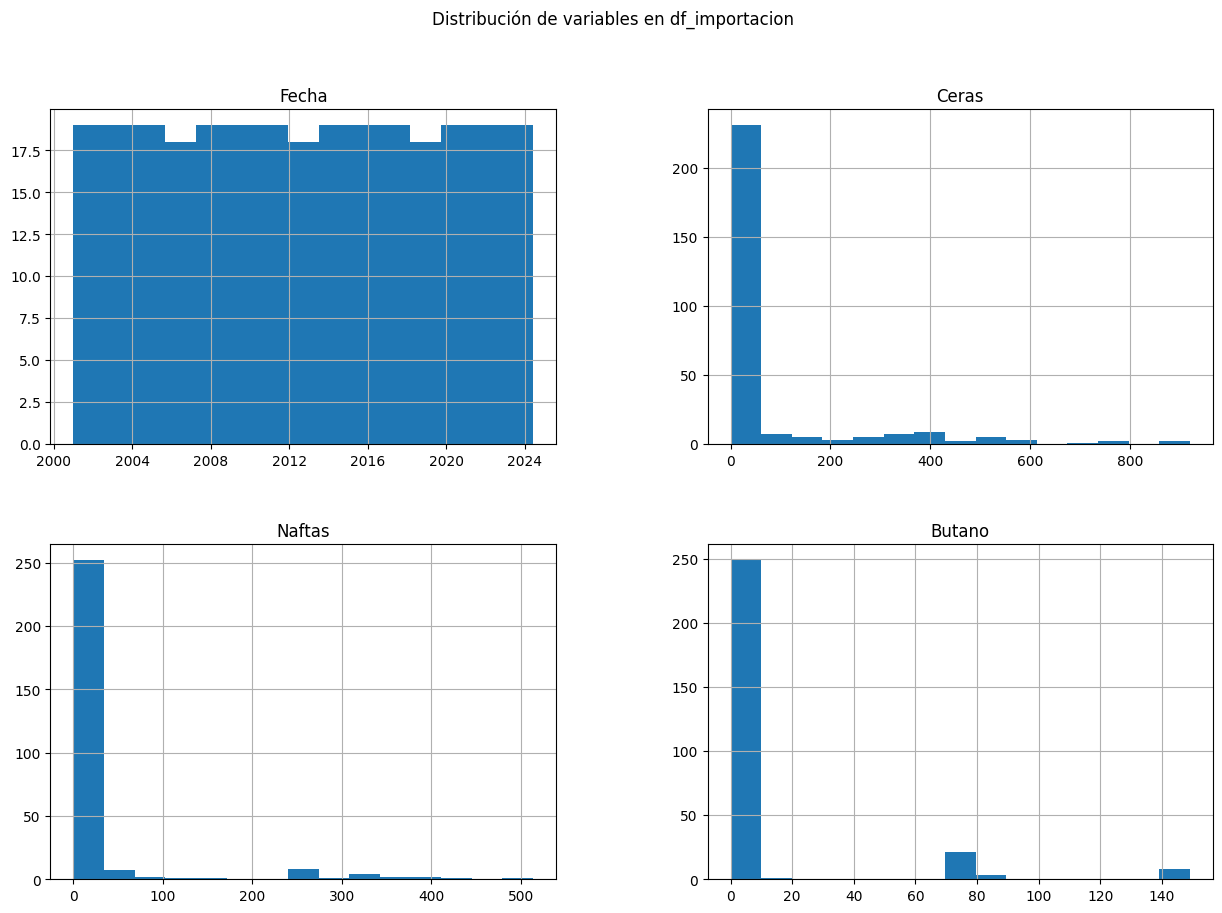

In [52]:
# Distribución de las variables numéricas en df_importacion
df_importacion.hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribución de variables en df_importacion')
plt.show()

In [53]:
df_importacion['Fecha'] = pd.to_datetime(df_importacion['Fecha'], format='%b/%Y')
print(df_importacion['Fecha'].head())

0   2001-01-01
1   2001-02-01
2   2001-03-01
3   2001-04-01
4   2001-05-01
Name: Fecha, dtype: datetime64[ns]


In [54]:
def convertir_a_numero(col):
    if col.dtype == 'object':  # Verifica si la columna es de tipo 'str'
        return pd.to_numeric(col.str.replace(',', '').str.replace('"', ''), errors='coerce')
    else:
        return col

# Aplicar la función a todas las columnas excepto la de 'Fecha'
for col in df_importacion.columns:
    if col != 'Fecha':
        df_importacion[col] = convertir_a_numero(df_importacion[col])

print(df_importacion)

         Fecha  Aceites lubricantes  Asfalto      Bunker  Ceras  \
0   2001-01-01                 0.00  27748.99  214581.84   0.00   
1   2001-02-01                 0.00   7503.57  294609.00   0.00   
2   2001-03-01                 0.00  26304.32  315263.80   0.00   
3   2001-04-01                 0.00   7885.89  205653.00   0.00   
4   2001-05-01                 0.00   8443.16  278371.30   0.00   
..         ...                  ...       ...        ...    ...   
277 2024-02-01             21374.61   5313.11  143951.95  95.09   
278 2024-03-01             27993.04   5633.41  163119.06   0.00   
279 2024-04-01             37444.60   7990.99   77253.65  33.52   
280 2024-05-01             32532.63  10483.78  544682.15  91.83   
281 2024-06-01             29845.57   9407.82  222899.55   0.00   

     Combustible turbo jet  Diesel bajo azufre  Diesel ultra bajo azufre  \
0                     0.00                0.00                      0.00   
1                     0.00                0

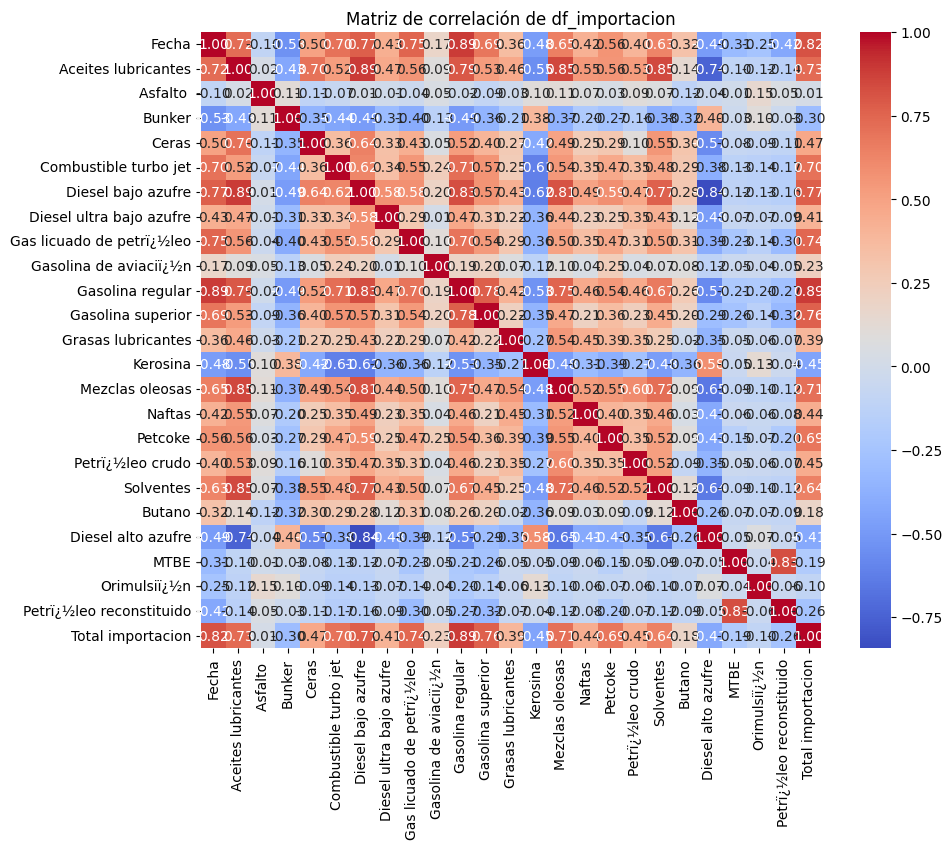

In [55]:
import seaborn as sns
# Matriz de correlación para df_importacion
plt.figure(figsize=(10, 8))
sns.heatmap(df_importacion.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación de df_importacion')
plt.show()

In [56]:
# Convertir columnas numéricas a tipo float (excepto la columna de fecha)
numerical_cols = df_importacion.columns.difference(['Fecha'])
df_importacion[numerical_cols] = df_importacion[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Verificar la conversión
print(df_importacion.dtypes)


Fecha                        datetime64[ns]
Aceites lubricantes                 float64
Asfalto                             float64
Bunker                              float64
Ceras                               float64
Combustible turbo jet               float64
Diesel bajo azufre                  float64
Diesel ultra bajo azufre            float64
Gas licuado de petrï¿½leo           float64
Gasolina de aviaciï¿½n              float64
Gasolina regular                    float64
Gasolina superior                   float64
Grasas lubricantes                  float64
Kerosina                            float64
Mezclas oleosas                     float64
Naftas                              float64
Petcoke                             float64
Petrï¿½leo crudo                    float64
Solventes                           float64
Butano                              float64
Diesel alto azufre                  float64
MTBE                                float64
Orimulsiï¿½n                    

In [57]:
print(df_importacion.columns)


Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petrï¿½leo',
       'Gasolina de aviaciï¿½n', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petrï¿½leo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsiï¿½n',
       'Petrï¿½leo reconstituido', 'Total importacion'],
      dtype='object')


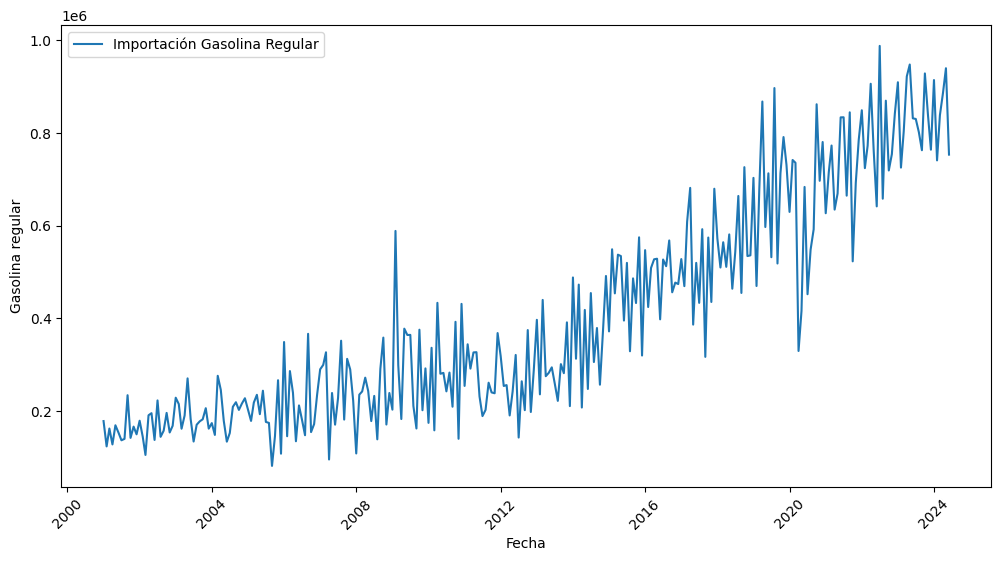

In [58]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_importacion, x='Fecha', y='Gasolina regular', label='Importación Gasolina Regular')

plt.xticks(rotation=45)
plt.show()


In [59]:
df_importacion.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petrï¿½leo,Gasolina de aviaciï¿½n,...,Naftas,Petcoke,Petrï¿½leo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsiï¿½n,Petrï¿½leo reconstituido,Total importacion
0,2001-01-01,0.0,27748.99,214581.84,0.0,0.0,0.0,0.0,194065.74,820.0,...,0.0,0.0,0.0,0.0,0.0,566101.99,8402.0,0.0,715344.0,2312639.05
1,2001-02-01,0.0,7503.57,294609.00,0.0,0.0,0.0,0.0,170703.38,3054.0,...,0.0,0.0,0.0,0.0,0.0,489525.80,0.0,0.0,370166.0,1769208.76
2,2001-03-01,0.0,26304.32,315263.80,0.0,0.0,0.0,0.0,161837.37,677.0,...,0.0,0.0,0.0,0.0,0.0,575559.68,0.0,0.0,360530.0,1945770.26
3,2001-04-01,0.0,7885.89,205653.00,0.0,0.0,0.0,0.0,163048.64,3399.0,...,0.0,0.0,0.0,0.0,0.0,437745.42,8184.0,0.0,359527.0,1623637.76
4,2001-05-01,0.0,8443.16,278371.30,0.0,0.0,0.0,0.0,171518.86,585.0,...,0.0,0.0,0.0,0.0,0.0,552609.13,12680.0,0.0,723346.0,2262726.64


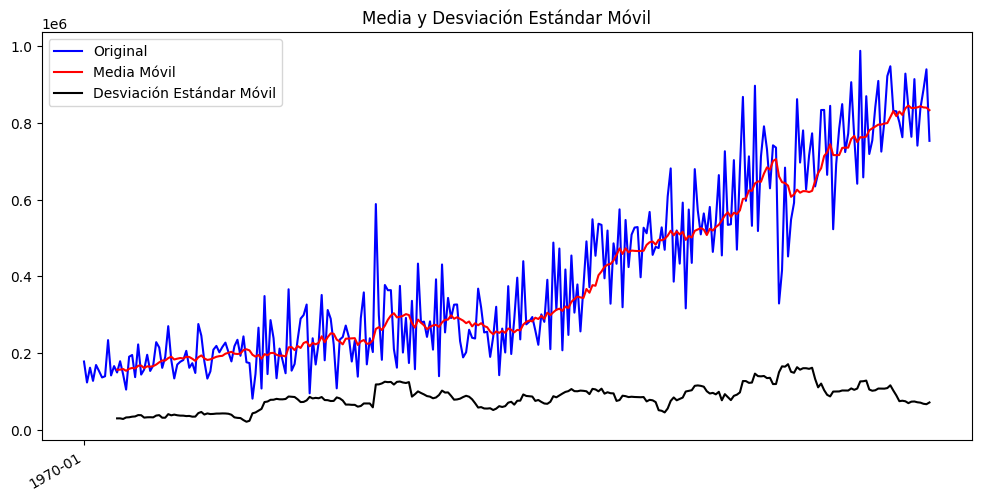

In [60]:
import matplotlib.dates as mdates
mediaMovil = df_importacion['Gasolina regular'].rolling(window=12).mean()
deMovil = df_importacion['Gasolina regular'].rolling(window=12).std()

# Configura el gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_importacion.index, df_importacion['Gasolina regular'], color="blue", label="Original")
plt.plot(df_importacion.index, mediaMovil, color='red', label='Media Móvil')
plt.plot(df_importacion.index, deMovil, color='black', label='Desviación Estándar Móvil')

# Formatear el eje x para que muestre las fechas correctamente
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  # Rotar las fechas para mejor visibilidad

# Añadir leyenda y título
plt.legend(loc='best')
plt.title('Media y Desviación Estándar Móvil')
plt.show()

In [61]:
print(df_importacion.columns)


Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petrï¿½leo',
       'Gasolina de aviaciï¿½n', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petrï¿½leo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsiï¿½n',
       'Petrï¿½leo reconstituido', 'Total importacion'],
      dtype='object')


In [62]:

importacion_regular = df_importacion[['Fecha', 'Gasolina regular']]
# Comprobar el índice
print(importacion_regular.index)

RangeIndex(start=0, stop=282, step=1)


In [68]:
# Convertir la columna 'Fecha' a tipo de datos datetime y establecerla como índice
importacion_regular['Fecha'] = pd.to_datetime(importacion_regular['Fecha'])
importacion_regular.set_index('Fecha', inplace=True)

C:\Users\josea\AppData\Local\Temp\ipykernel_18280\4072103390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importacion_regular['Fecha'] = pd.to_datetime(importacion_regular['Fecha'])


In [69]:
importacion_regular.head()

,Gasolina regular
Fecha,
2001-01-01,177776.50
2001-02-01,123115.99
2001-03-01,161726.42
2001-04-01,127338.74
2001-05-01,168730.19


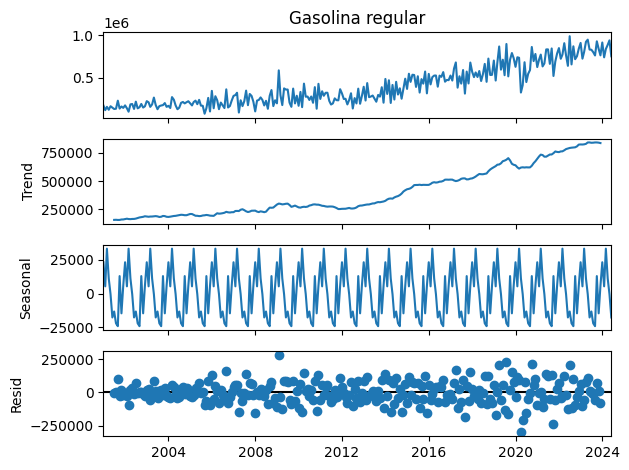

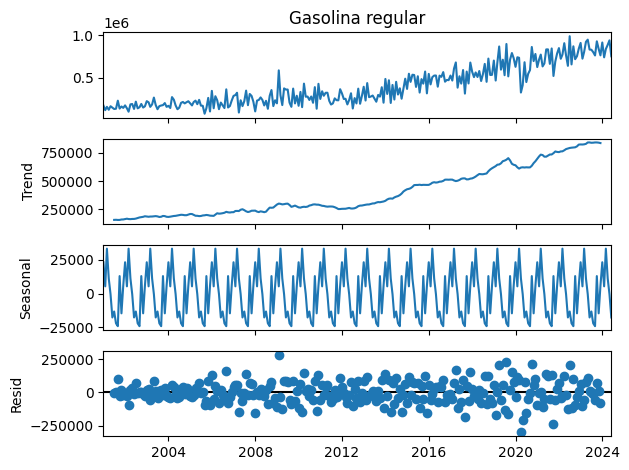

In [70]:

# Descomponer la serie temporal
descomposicion = seasonal_decompose(importacion_regular['Gasolina regular'], model='additive')
descomposicion.plot()

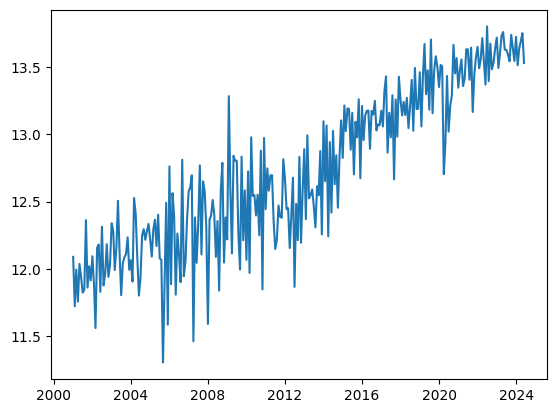

In [94]:
ts_importacion_log = np.log(importacion_regular)
plt.plot(ts_importacion_log)

In [72]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(importacion_regular['Gasolina regular'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.707353
p-value                        0.989983
# de retardos usados           9.000000
# de observaciones usadas    272.000000
Critical Value (1%)           -3.454622
Critical Value (5%)           -2.872225
Critical Value (10%)          -2.572464
dtype: float64


In [92]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_importacion_diff = importacion_regular['Gasolina regular'].diff()
ts_importacion_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_importacion_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.018949e+01
p-value                      6.377492e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.730000e+02
Critical Value (1%)         -3.454533e+00
Critical Value (5%)         -2.872186e+00
Critical Value (10%)        -2.572443e+00
dtype: float64


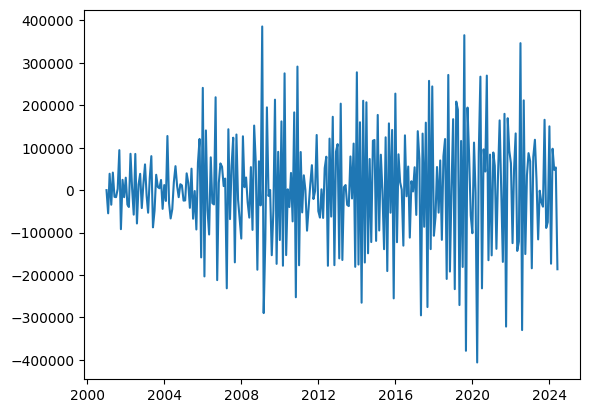

In [93]:
plt.plot(ts_importacion_diff)

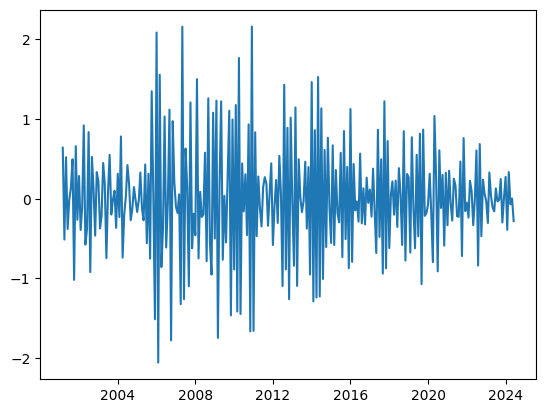

In [95]:
plt.plot(ts_importacion_log.diff().diff())

In [76]:
ts_importacion_diff_df = ts_importacion_diff.to_frame()

# Escalar los datos
scaler = StandardScaler()
ts_consumo_scaled = scaler.fit_transform(ts_importacion_diff_df)

# Ver los primeros 6 valores escalados
ts_consumo_scaled[1:7]

array([[-0.42119107],
       [ 0.27165465],
       [-0.27059814],
       [ 0.29231294],
       [-0.13275406],
       [-0.1384654 ]])

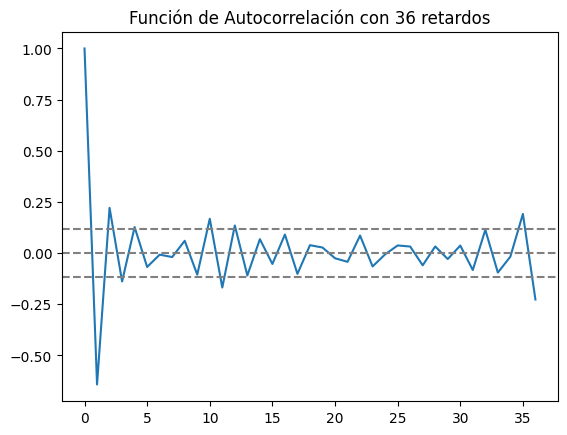

In [97]:
from statsmodels.tsa.stattools import acf, pacf
plt.plot(acf(ts_importacion_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importacion_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importacion_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [77]:
entrenamiento = round(0.6*len(ts_consumo_scaled))
val_prueba = round(0.2*len(ts_consumo_scaled))
test = ts_consumo_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_consumo_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_consumo_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

58

In [78]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [79]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

In [80]:
# Definir los parámetros
unidades = 1
paso = 3
caracteristicas = 1  # Es univariada

# Crear el modelo LSTM
modelo1 = Sequential()
modelo1.add(LSTM(units=unidades, input_shape=(paso, caracteristicas)))
modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [81]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [82]:
lote = 1
epocas = 100
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3933 - val_loss: 1.5178
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.3896 - val_loss: 1.5068
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.3874 - val_loss: 1.4980
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.3852 - val_loss: 1.4848
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.3818 - val_loss: 1.4665
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.3773 - val_loss: 1.4436
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.3717 - val_loss: 1.4163
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.3652 - val_loss: 1.3852
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.3579 - val_loss: 1.3510
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.3500 - val_loss: 1.3146
Epoch 11/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.3419 - val_loss: 1.2767
Epoch 12/100
169/169 

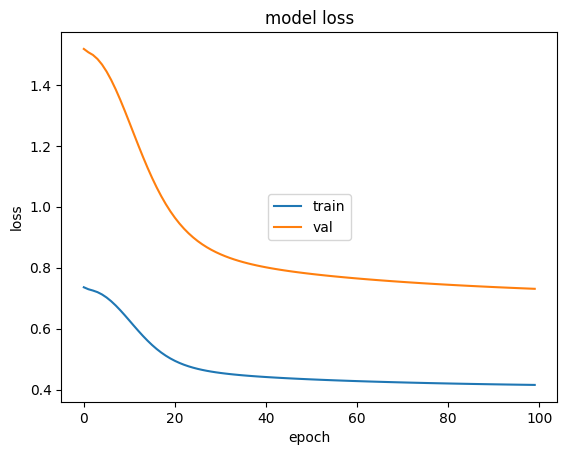

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [84]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.3202
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6537 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1386 


1.0732879638671875

In [85]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importacion_regular.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importacion_regular.values , n=entrenamiento+val_prueba)


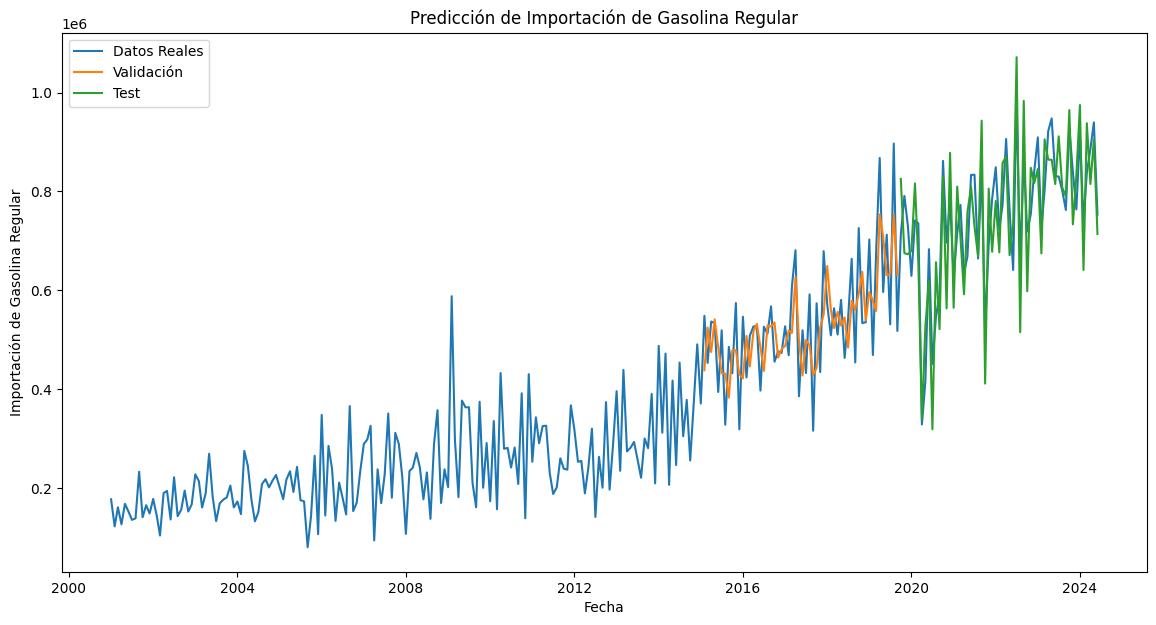

In [98]:
# Crear DataFrames para las predicciones
df_val = pd.DataFrame(prediccion_val, index=importacion_regular[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test, index=importacion_regular[entrenamiento+len(df_val):len(importacion_regular['Gasolina regular'])].index)

# Ajustar el tamaño de la figura
plt.figure(figsize=(14, 7))  # Aumenta el ancho a 14 pulgadas y la altura a 7 pulgadas

# Graficar
plt.plot(importacion_regular['Gasolina regular'], label='Datos Reales')
plt.plot(df_val, label='Validación')
plt.plot(df_test, label='Test')

# Añadir título y etiquetas
plt.title('Predicción de Importación de Gasolina Regular')
plt.xlabel('Fecha')
plt.ylabel('Importación de Gasolina Regular')

# Mostrar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


# Segundo modelo con dos capas

In [100]:
# Transformar a una serie supervisada
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos), 0]
        valor_sig = serie[i+retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)




In [101]:
x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)

# Ajustar las dimensiones para el modelo LSTM
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_val = np.reshape(x_val, (x_val.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))

In [102]:
modelo2 = Sequential()

modelo2.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
modelo2.add(LSTM(units=25))  # Segunda capa LSTM
modelo2.add(Dense(1))

modelo2.summary()

modelo2.compile(loss='mean_squared_error', optimizer="adam")

c:\Users\josea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4258 - val_loss: 1.4592
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4128 - val_loss: 1.3950
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3964 - val_loss: 1.3075
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3738 - val_loss: 1.1879
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3444 - val_loss: 1.0397
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3119 - val_loss: 0.8883
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2856 - val_loss: 0.7731
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2736 - val_loss: 0.7121
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2736 - val_loss: 0.6884
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2762 - val_loss: 0.6805
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2772 - val_loss: 0.6779
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

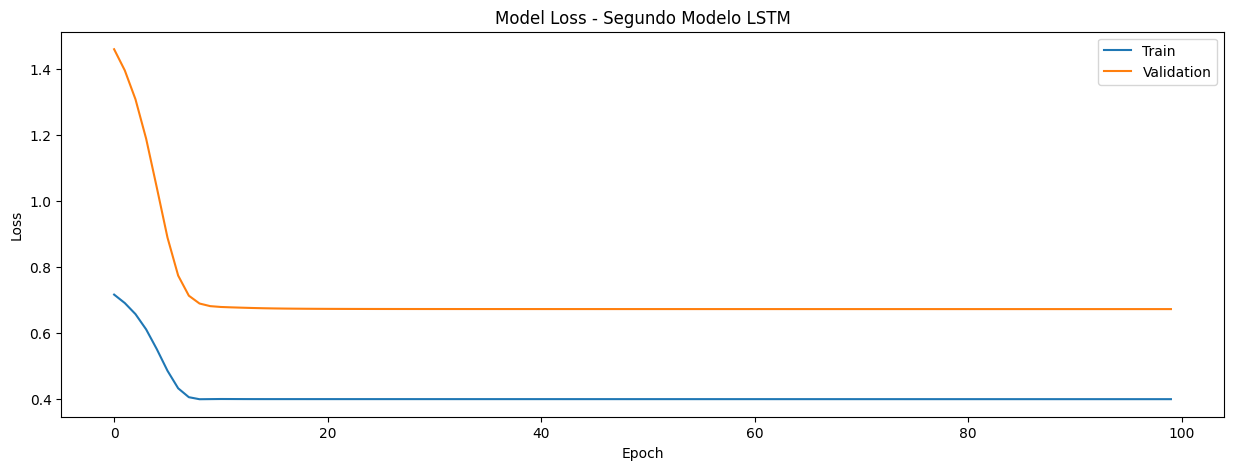

In [103]:
# Ajustar el modelo con un tamaño de lote mayor y más épocas
lote = 10  
epocas = 100  

history2 = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    verbose=1
)

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss - Segundo Modelo LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [104]:

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * (len(data))
    i = 0
    for X in data:
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[(n + dif_cant * i)]
        prediccion[i] = yhat[0][0]
        i += 1
    return prediccion


In [106]:
prediccion_val2 = prediccion_fun(x_val, modelo2, lote, scaler, dif=True, dif_cant=1, Series=importacion_regular.values, n=entrenamiento)
prediccion_test2 = prediccion_fun(x_test, modelo2, lote, scaler, dif=True, dif_cant=1, Series=importacion_regular.values, n=entrenamiento+val_prueba)


In [108]:
df_val2 = pd.DataFrame(prediccion_val2, index=importacion_regular[(entrenamiento):entrenamiento+val_prueba].index)
df_test2 = pd.DataFrame(prediccion_test2, index=importacion_regular[entrenamiento+len(df_val2):len(importacion_regular['Gasolina regular'])].index)

In [109]:
plt.plot(importacion_regular['Gasolina regular'], label='Real')
plt.plot(df_val2, label='Predicción Validación')
plt.plot(df_test2, label='Predicción Prueba')
plt.title('Predicciones con el Segundo Modelo LSTM')
plt.legend()
plt.show()

NameError: name 'consumo_regular' is not defined